In [1]:
#computes classification accuracy for orofacial movements, single phonemes, and single words for a given brain area
#(Fig 1d)
baseDir = '/oak/stanford/groups/henderj/fwillett/speechPaperRelease_08_20/'

In [2]:
import scipy.io

brainArea='6v' #brainArea='6v' or brainArea='44'
phonemesDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')

In [3]:
#mean-subtract within block
import numpy as np
def meanSubtract(dat):
    if brainArea=='6v':
        dat['feat'] = np.concatenate([dat['tx2'][:,0:128].astype(np.float32), dat['spikePow'][:,0:128].astype(np.float32)], axis=1)
    elif brainArea=='44':
        dat['feat'] = np.concatenate([dat['tx2'][:,128:].astype(np.float32), dat['spikePow'][:,128:].astype(np.float32)], axis=1)
        
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

#mean subtraction
phonemesDat = meanSubtract(phonemesDat)
orofacialDat = meanSubtract(orofacialDat)
fiftyWordDat = meanSubtract(fiftyWordDat)

In [4]:
from analysis import triggeredAvg

fAvg_phones, fCI_phones, trials_phones = triggeredAvg(phonemesDat['feat'].astype(np.float32), 
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-50,50], smoothSD=4)

/home/groups/henderj/fwillett/code/speechRelease_v3/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
fAvg_orofacial, fCI_orofacial, trials_orofacial = triggeredAvg(orofacialDat['feat'].astype(np.float32), 
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), [-50,50], smoothSD=4)

In [6]:
fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['feat'].astype(np.float32), 
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-50,50], smoothSD=4)

In [7]:
from analysis import gnb_loo, bootCI

def plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, title, figName):
    #confusion matrices
    codeList = np.unique(unroll_y)
    nCodes = len(codeList)
    cMat = np.zeros([nCodes, nCodes])

    for x in range(nCodes):
        for y in range(nCodes):
            thisSum = np.sum(np.logical_and(unroll_y==codeList[orderIdx[x]], y_pred==codeList[orderIdx[y]]))
            cMat[x,y] = thisSum

    for x in range(nCodes):
        cMat[x,:] = cMat[x,:] / np.sum(cMat[x,:])    
        
    import matplotlib.pyplot as plt
    from analysis import plotPreamble
    plotPreamble()

    plt.figure(figsize=(5,5), dpi=300)
    plt.imshow(cMat,clim=[0,1])

    reorderLabels = []
    for x in range(len(tickLabels)):
        reorderLabels.append(tickLabels[orderIdx[x]])
        
    plt.xticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)

    plt.show()

In [8]:
#classify amongst all conditions EXCEPT "do nothing"
phonemeCuesToUse = np.array([0,1,3,4,5,6,7,8,9,10,11,12,14,15,16,17,19,20,21,22,23,24,
                      26,27,28,29,30,31,32,33,34,35,36,37,38,39]).astype(np.int32)
oroCuesToUse = np.array([0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                         21,22,23,24,25,26,27,28,29,30,31,32,33]).astype(np.int32)
fiftyWordCuesToUse = np.arange(1,51).astype(np.int32)

In [9]:
#--phonemes--

In [10]:
trials_phones_subset = []
for t in range(len(phonemeCuesToUse)):
    trials_phones_subset.append(trials_phones[phonemeCuesToUse[t]])

y_pred, unroll_y = gnb_loo(trials_phones_subset, [50,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))
print(bootCI(y_pred, unroll_y))

0.609375
[0.56944444 0.64930556]


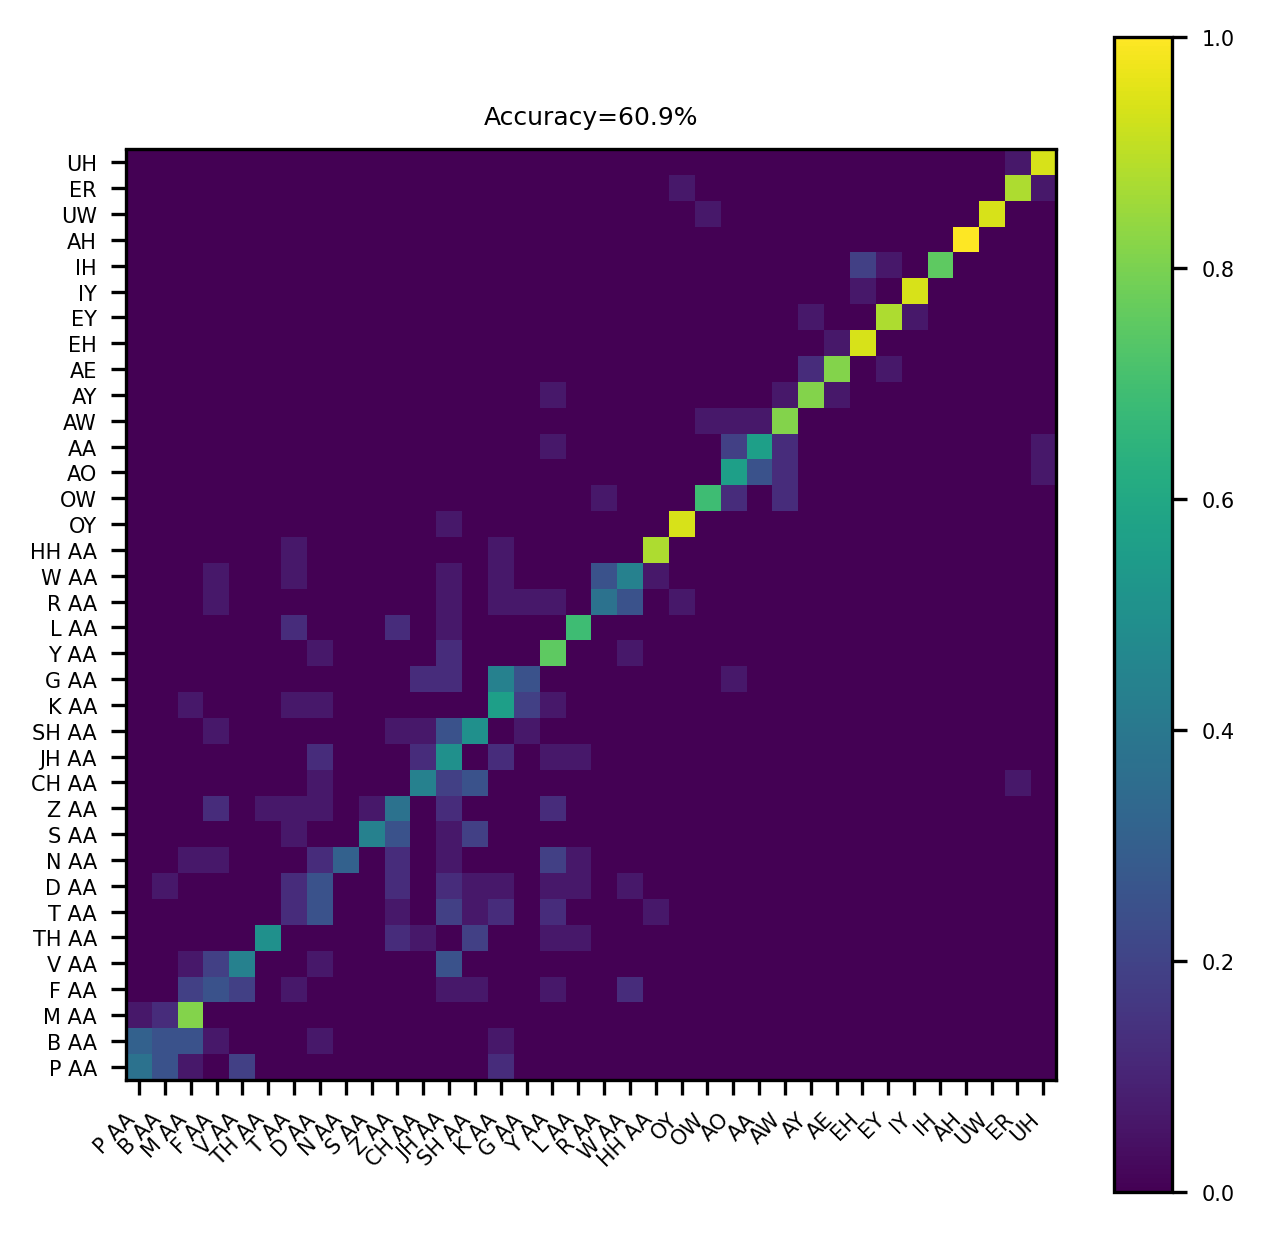

In [11]:
tickLabels = ['B AA','CH AA','D AA','F AA',
             'G AA','HH AA','JH AA','K AA',
             'L AA','ER','M AA','N AA',
             'P AA','R AA','S AA','SH AA','T AA','TH AA',
             'V AA','W AA','Y AA','Z AA',
             'OY','EH','EY','UH','IY','OW',
             'UW','IH','AA','AW','AY','AH','AO','AE']

tickLabelsReorder = ['P AA','B AA','M AA','F AA',
             'V AA','TH AA','T AA','D AA',
             'N AA','S AA','Z AA','CH AA',
             'JH AA','SH AA','K AA','G AA','Y AA','L AA',
             'R AA','W AA','HH AA','OY','OW',
             'AO','AA','AW','AY','AE','EH',
             'EY','IY','IH','AH','UW','ER','UH']

orderIdx = []
for x in range(len(tickLabelsReorder)):
    for y in range(len(tickLabels)):
        if tickLabels[y]==tickLabelsReorder[x]:
            orderIdx.append(y)
            break
            
orderIdx = np.array(orderIdx).astype(np.int32)
plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, 
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%', 
                    'phonemeConfusionMatrix_'+brainArea)

In [12]:
#--orofacial movements--

In [13]:
trials_orofacial_subset = []
for t in range(len(oroCuesToUse)):
    trials_orofacial_subset.append(trials_orofacial[oroCuesToUse[t]])
    
y_pred, unroll_y = gnb_loo(trials_orofacial_subset, [50,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))
print(bootCI(y_pred, unroll_y))

0.9121212121212121
[0.88939394 0.93333333]


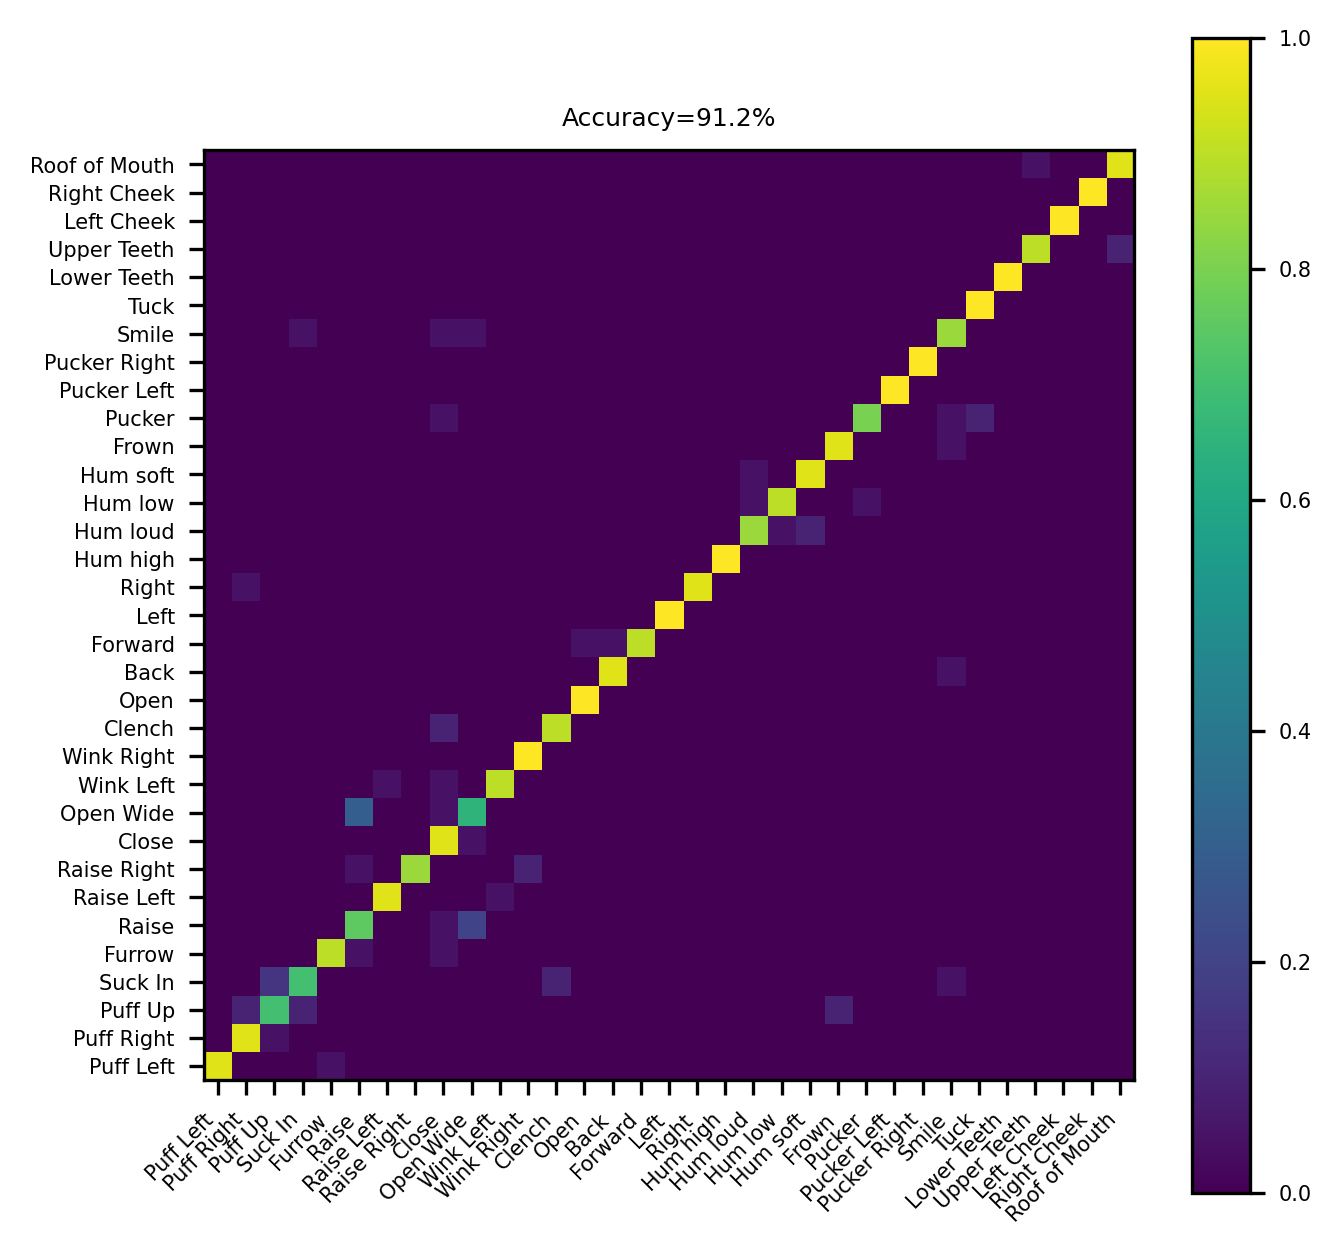

In [14]:
tickLabels = ['Puff Left','Puff Right','Puff Up','Suck In',
                 'Furrow','Raise','Raise Left','Raise Right',
                 'Close','Open Wide','Wink Left','Wink Right',
                 'Clench','Open','Back','Forward','Left','Right',
                 'Hum high','Hum loud','Hum low','Hum soft',
                 'Frown','Pucker','Pucker Left','Pucker Right','Smile','Tuck',
                 'Lower Teeth','Upper Teeth','Left Cheek','Right Cheek','Roof of Mouth']
    
plotConfusionMatrix(unroll_y, y_pred, tickLabels, np.arange(0,34).astype(np.int32), 
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%',
                    'orofacialConfusionMatrix_'+brainArea)

In [15]:
#--fifty word set--

In [16]:
trials_fiftyWord_subset = []
for t in range(len(fiftyWordCuesToUse)):
    trials_fiftyWord_subset.append(trials_fiftyWord[fiftyWordCuesToUse[t]])
    
y_pred, unroll_y = gnb_loo(trials_fiftyWord_subset, [50,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))
print(bootCI(y_pred, unroll_y))

0.941
[0.926 0.956]


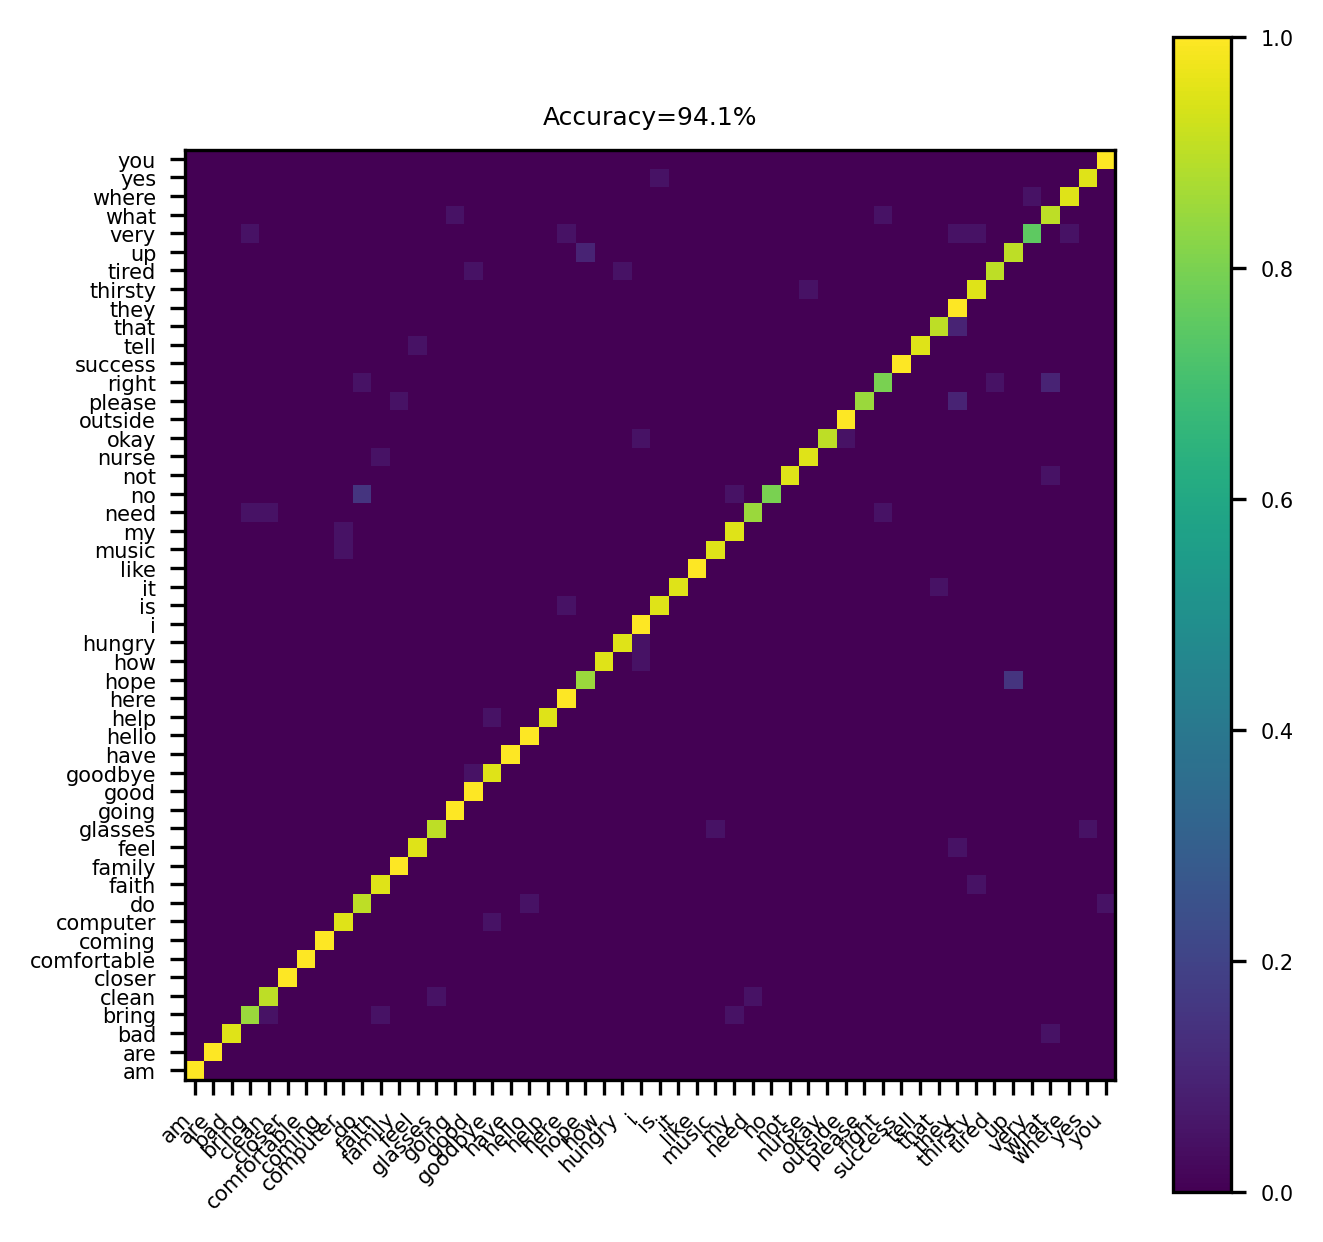

In [17]:
tickLabels = fiftyWordDat['cueList'][0,1:51]
fixedLabels = []
for x in range(len(tickLabels)):
    fixedLabels.append(tickLabels[x][0])
    
orderIdx = np.arange(0,50).astype(np.int32)
plotConfusionMatrix(unroll_y, y_pred, fixedLabels, orderIdx, 
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%', 
                    'fiftyWordConfusionMatrix_'+brainArea)